# 선형 회귀 (Linear Regression)

Date: 2019-8-15  
Author: skettee  
Categories: Deep Learning, Linear Regression  
Tags: 딥러닝, 선형회귀, 경사하강법  
Description: 딥러닝 모델링
<!--eofm-->


**딥러닝의 세계로 들어가기 위해 알아야 하는 첫번째 모델인 선형 회귀(Linear Regression)에 대해 알아보고 python과 keras를 이용해서 모델링을 해보자!**
<!--more-->

실제로 돌려 보고 싶으면 구글 코랩으로 ~  

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/skettee/notebooks/linear_regression.ipynb)


## 문제 (Problem)

💰 고객

> 서로 다른 높이에서 공을 떨어뜨려서   
> 땅에 닫는 시간을 측정한 데이터가 있네.     
>
> 이 데이터를 가지고   
> 땅에 떨어지는 시간이 주어지면   
> 떨어뜨린 높이를 자동으로 알고 싶네.    
>
> 만들어 줄 수 있지? 
>
> 데이터는 아래에 있네

In [1]:
import numpy as np

def get_data():
    np.random.seed(1)
    data_size = 50
    x = np.linspace(10, 1000, data_size)
    y = np.sqrt(x/9.80665)
    y += np.random.uniform(-0.01, 0.01, data_size)
    return x, y

In [2]:
height_data, time_data = get_data()

print('data length = ', len(height_data))
print('\nheight(m) data = ', height_data[:10])
print('\ntime(sec) data = ', time_data[:10])

data length =  50

height(m) data =  [ 10.          30.20408163  50.40816327  70.6122449   90.81632653
 111.02040816 131.2244898  151.42857143 171.63265306 191.83673469]

time(sec) data =  [1.00815043 1.75938774 2.25720368 2.67941116 3.03607298 3.3565059
 3.65175391 3.92646805 4.18143387 4.42366033]


## 데이터 분석 (Data Analysis)

⚙️ 엔지니어

> 데이터가 어떤 모양인지    
> 확인해 보아야 겠군

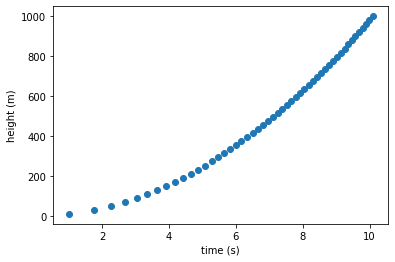

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.scatter(time_data, height_data)
plt.xlabel('time (s)')
plt.ylabel('height (m)')
plt.show()

⚙️ 엔지니어

> 데이터가 많이 휘어 있군...   
> 지금 나는 직선으로만 모델링을 할 수 있는데...   
> 
> 이러면 나가린데...  

## 데이터 변환 (Data Transformation)

⚙️ 엔지니어

> 어라... 가만히 보니 이 그래프 어디에서 많이 본건데...  
> 이거 $y=ax^2 (a\geqq0, x\geqq0)$ 그래프 잖아!   
> 
> 음... 거리가 늘어날 수록 시간은 제곱으로 늘어난다는 것인데...   
> 그렇다면 거리와 시간의 제곱은 비례할 거고   
> 시간 데이터를 시간의 제곱 데이터로 변환하면   
> 둘 사이의 관계가 직선에 가깝게 될 거 같군.

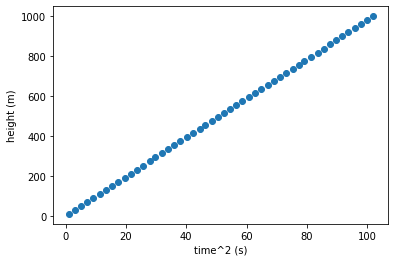

In [4]:
time2_data = time_data * time_data

plt.scatter(time2_data, height_data)
plt.xlabel('time^2 (s)')
plt.ylabel('height (m)')
plt.show()

⚙️ 엔지니어

> 좋았어!   
> 
> 그럼 변환된 데이터로 선형회귀(Linear Regression) 모델링을 시작해 보지

In [5]:
x = time2_data
y = height_data

print('x = ', x[:10])
print('x.shape= ', x.shape)
print('\ny = ', y[:10])
print('y.shape= ', y.shape)

x =  [ 1.01636729  3.09544521  5.09496843  7.17924417  9.21773915 11.26613183
 13.33530659 15.41715136 17.48438924 19.56877074]
x.shape=  (50,)

y =  [ 10.          30.20408163  50.40816327  70.6122449   90.81632653
 111.02040816 131.2244898  151.42857143 171.63265306 191.83673469]
y.shape=  (50,)


## 선형 모델링 (Linear Modeling)

⚙️ 엔지니어) 

> 모델을 $y=wx+b$로 놓고   
> 주어진 데이터에 가장 가까운 직선을 표시하는   
> $w$와 $b$를 구하면 끝!   
> 
> $w$는 직선의 기울기고 $b$는 $y$절편이라고 배웠지만,   
> 이제 부터는 $w$는 **weight**고   
> $b$는 **bias**로 부르도록 하겠다...   
>
> 왜? 멋있으니까!    
>
> 그런데... $w$와 $b$를 어떻게 구하면 되지?


### 손실 함수 (Loss function)

⚙️ 엔지니어

> 남여 커플 10명이 모여서 게임을 시작한다.  
> 남자는 여자친구의 몸무게를 말하고 가장 근접한 몸무게를 맞추는 커플이 1등이 된다.  
> 1등을 정하는 방법은 남자가 말한 몸무게와 여자친구가 말한 실제 몸무게의 차이를 점수로 계산하고,  
> 가장 점수가 낮은(가장 비슷하게 맞춘) 커플에게 1등을 주면 된다.  
>
> 실제로 점수를 계산할 때에는 단순한 차이값을 사용하지 않고  
> 차이값을 제곱하고 반으로 나누어 준 값을 사용한다.    
>
> 그리고 커플 10명 전체에 대한 점수는 각 커플들의 점수의 평균을 내면 된다.

하나의 데이터 세트($x^{(i)}, y^{(i)}$)를 사용해서 모델에서 얻은 값과 실제 값과의 차이(Loss)를 구하는 함수를 구해보자.  
여기서 $x^{(i)}$는 i번째 $x$값이고 $y^{(i)}$은 i번째 $y$값이다.  

일단 $w$와 $b$는 임의의 값으로 놓자. 그리고 모델에 $x^{(i)}$을 넣고 계산한 결과 값 ${\hat y}^{(i)}$과 실제 값 $y^{(i)}$의 차이를 구한다. 선형 모델링에서는 제곱 오차(squred error)를 사용한다.

$L({\hat y}^{(i)}, y^{(i)})={1\over2}({\hat y}^{(i)}-y^{(i)})^2$

모든 데이터(m개의 데이터 세트)로 부터 얻은 것을 평균(mean squred error)한것이 손실 함수(Loss function)이다. 손실 함수는 $w$와 $b$의 함수로 나타낼 수 있다.

${\large J}(w, b) = {1\over m}\sum_{i=1}^m L({\hat y}^{(i)}, y^{(i)}) = {1\over {2m}}\sum_{i=1}^m ({\hat y}^{(i)}-y^{(i)})^2$

⚙️ 엔지니어

> 손실 함수   
> 
> ${\large J}(w, b) = {1\over {2m}}\sum_{i=1}^m ({\hat y}^{(i)}-y^{(i)})^2$  
>
> 가 최소가 되는 $w$와 $b$를 찾으면 되겠군!

**손실 함수 (Loss function) 시각화**

⚙️ 엔지니어

> 우선 손실 함수(Loss function)가 어떻게 생겨 먹었는지 살펴 보자.  
> x축을 $w$로 놓고, y축을 $b$로 놓고, z축을 손실 함수 ${\large J}(w, b)$로 
> 그래프를 그려 보면  
> 어떻게 최소값을 찾을지 감이 올 것 같다.   
>
> 일단 $w$는 딱봐도 양수니까   
> $0\leqq w \leqq 20.0$ 정도로 잡고,  
> $b$는 $-10.0\leqq b \leqq 10.0$으로 잡아보자.   
> 간격은 0.1 간격으로

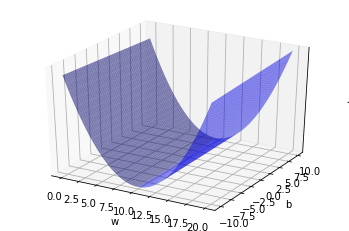

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error
from mpl_toolkits import mplot3d

# W,b의 범위를 결정한다.
w = np.arange(0, 20.0, 0.1)
b = np.arange(-10.0, 10.0, 0.1)
j_array = []

# (200, 200) 매트릭스로 변환한다.
W, B = np.meshgrid(w, b)

# w, b를 하나씩 대응한다.
for we, be in zip(np.ravel(W), np.ravel(B)):
    y_hat = np.add(np.multiply(we, x), be)
    # Cost function
    mse = mean_squared_error(y_hat, y) / 2.0
    j_array.append(mse)

# 손실(Loss)을 구하고 (200, 200) 매트릭스로 변환한다.
J = np.array(j_array).reshape(W.shape)

# 서피스 그래프를 그린다.
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.plot_surface(W, B, J, color='b', alpha=0.5)
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('J')
ax.set_zticks([])
plt.show()

⚙️ 엔지니어

> U 모양으로 구부러진 모양이다!  
> $w$가 10근처에서 손실 함수가 최소값을 가지는 것을 볼 수 있다.  
>
> $b$는 손실 함수가 최소가 되는 값이 잘 보이지 않는다.   
> 확대를 하면 보이겠지만 귀찮다.  
>
> 이제 램덤하게 $w$와 $b$값이 주어지더라도   
> 자동으로 손실 함수의 최소값을 찾는 방법을 찾으면 된다.  
>
> 어떻게 자동으로 찾지?

### 경사 하강법 (Gradient Descent)

⚙️ 엔지니어

> 등산에서 쓰는 말처럼 들리는 이 방법은  
> 내가 현재 있는 산의 위치에서   
> 경사(기울기)를 확인하고   
> 경사가 아래인 방향으로 한걸음 내려가고,   
> 경사를 확인하고,   
> 또 한걸음 내려가고를   
> 계속 반복하면   
> 결국 골짜기 가장 아래로 도착할 수 있다는 방법이다.    
>
> 여기서 경사를 확인 하는 방법이   
> **미분**이다.   
> 
> 잘 모르겠다고?   
> 아래에 간단한 예제를 보자

**이차 함수에서 미분으로 최소값 찾기**

$y=x^2-2x+4$에서 $y$가 최소가 되는 $x$값을 미분으로 구해 보자.  
* 참고로 $y=(x-1)^2 +3$으로 정리하면 $x=1$일때 $y$는 최소값 3을 갖는다는 것을 알 수 있다.

1. $x$값을 아무거나 하나 선택한다. 여기서는 $x=3$을 선택하자
2. $x=3$일때 순간 변화율을 계산한다. 순간 변화율은 미분이다. ${dy\over dx}=2x-2$ 이므로 순간 변화율은 4이다.
3. 순간 변화율이 0보다 크면 $x$를 -방향으로 이동한다. 이떄 얼마나 이동하느냐가 중요한데 순간 변화율 4만큼 이동하면 최소값을 지나쳐 버린다. 따라서 조금씩 움직이도록 순간 변화율에 0.01배 만큼 움직이게 한다. ($x$를 0.04 만큼 -방향으로 이동한다. 즉 $x=2.96$)
4. 순간 변화율이 0보다 작으면 x를 +방향으로 이동한다. 위와 마찬가지로 미분값에 0.01배 만큼 움직이게 한다. 여기서 0.01을 learning rate라고 하고 $\alpha$로 표시한다.
5. 1000번 반복한다.

In [7]:
def derivative(x):
    dydx = 2*x-2
    return dydx
    
epoch = 1000 # 반복 개수
learning_rate = 0.01 # alpha

xx = 3 # 초기 x값

for i in range(epoch):
    xx = xx - learning_rate * derivative(xx)
    
print('x for minimum y is: ', xx)

x for minimum y is:  1.0000000033659349


⚙️ 엔지니어

> 좋았어!   
>
> $w$와 $b$에 대한 손실 함수의 순간 변화율을 구해서   
> 반복해서 업데이트를 해 주면   
> 자동으로 손실 함수의 최소 값에 도달 할 수 있겠어!   
> 
> 수식으로 표현해보자
>
> REPEAT(epoch) {    
> $w:=w-\alpha {\partial {J(w,b)}\over \partial w}$    
>
> $b:=b-\alpha {\partial{J(w,b)}\over \partial b}$ , $\alpha=0.01$ learining rate    
> }
>
> 아하! **손실함수의 최소값을 찾아 가는 것**이 기계(Machine)가 학습(Learning)하는 방법이구나!

### 정리

⚙️ 엔지니어

> 선형 모델(Linear model)을 만드는 방법을 정리해 보자.  
> 1. $\hat{y}=wx+b$ 함수를 정의한다.  
> 2. 손실 함수 (Loss function)를 정의한다. 여기서는 평균 제곱 오차(mean squared error)를 사용한다.  
> 3. 손실 함수의 최소값을 찾는 방법을 선택한다. 여기서는 경사 하강법(gradient descnet)를 사용한다. 그리고 최소값을 찾는 방법(알고리즘)을 옵티마이저(Optimizer)라고 부르겠다.  
> 4. 설정된 회수(~~1000~~40000번) 만큼 반복해서 주어진 데이터로 모델을 최적화(fit) 시킨다.  

## 텐서플로우(Tensorflow)로 모델링(Modeling)

⚙️ 엔지니어

> 좋았어!   
> 
> 이제 텐서플로우(Tensorflow)가 냠냠한   
> **케라스(Keras)**를 이용해서 구현을 해보자!

### 정규화(Normalization)

⚙️ 엔지니어  

> 내가 해봐서 아는데...   
> 
> 이거 안하면 엉뚱한 답이 나온다.
> 꼭 해야됨!

In [8]:
# 정규화 (Normalization)
norm= np.linalg.norm(x)
X_train = x / norm
Y_train = y / norm

print('X_train= ', X_train[:10])
print('\nY_train= ', Y_train[:10])


X_train=  [0.00241728 0.00736205 0.01211761 0.01707475 0.021923   0.02679479
 0.03171601 0.03666737 0.04158398 0.04654137]

Y_train=  [0.02378349 0.07183585 0.11988821 0.16794057 0.21599293 0.26404529
 0.31209765 0.36015    0.40820236 0.45625472]


### Keras를 가지고 모델링(Modeling)하기

⚙️ 엔지니어

> 4줄로 모델링이 가능하다!   
> 
> 케라스 만세!

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# 모델을 준비한다.
model = Sequential()

# 입력 변수가 1이고 출력 개수가 1인 y=wx+b (Dense)를 생성한다.
model.add(Dense(1, input_shape=(1,)))

# Loss funtion과 Optimizer를 선택한다.
model.compile(loss='mean_squared_error', optimizer='sgd') 

# epochs만큼 반복해서 손실값이 최저가 되도록 모델을 훈련한다.
hist = model.fit(X_train, Y_train, epochs=40000, verbose=0) 

W0812 23:01:41.166896 4420593088 deprecation.py:506] From /Users/skettee/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### 손실값의 변화를 그래프로 확인

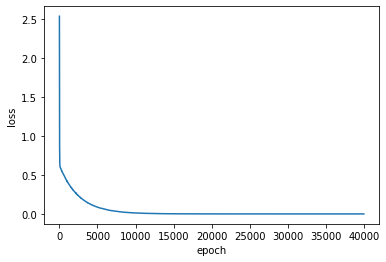

In [10]:
plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

⚙️ 엔지니어

> 반복적으로 학습할 수록 손실(Loss)이 0에 가깝게 된다.  
> 굿잡!

### $w$와 $b$값을 확인

In [11]:
w, b = model.get_weights()
print('w: ', w[0][0])
print('b: ', b[0])

w:  9.800606
b:  0.0008281114


⚙️ 엔지니어

> $\hat{y}=9.80x$ 이다.  
> 어... $y$의 단위는 $m$(meter)이고 $x$는 $sec^2$이니까...  
> 9.8은 바로 중력 가속도이다!  

## 해결 (Solution)

⚙️ 엔지니어  

> 고객님~ 원하시는 솔루션입니다.   
> input_time에 원하시는 시간을 입력하시면   
> 예상되는 높이가 자동으로 계산됩니다.    
> 
> 그런데 고객님~   
> 이 모델은 중력 가속도($9.8m/sec^2$)모델인데...   
>
> 혹시 고객님 성이 갈씨?

In [12]:
input_time = 1.0

predict = model.predict([input_time*input_time])

print('Predicted height = {:.3f} m'.format(predict[0][0]))

Predicted height = 9.801 m
